In [1]:
setwd("/home/pasoneto/Documents/github/doc_suomi/code")
source("utils.R")
source("data_cook.R")
cat(howto_data)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘DescTools’


The following object is masked from ‘package:data.table’:

    %like%


The following objects are masked from ‘package:caret’:

    MAE, RMSE



Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train


`summarise()` regrouping output by 'album_id' (override with `.groups` argument)



How to use datasets
 
call    base()             for real values
call    z_scored()         for normalized
call    min_maxed()        for normalized2
call    upsampled_album()  for binded upsamplped albums
call    list_upsampled()   for list of upsampled albums
call    low()              for normalized low level
call    low_upsampled()    for normalized and upsampled low level

# Dissimilarities 1

Dissimilarities with nearest neighbors upsampling. Each album was upsampled to 16 tracks, and then dissimilarities were calculated.

In [ ]:
# Reading upsampled albums
file_list <- list.files(path="/home/pasoneto/Documents/github/doc_suomi/data/dissimilarities/upsampled_nearest")
matrices = c()

# Reading files
for(i in 1:length(file_list)){
    file = paste("/home/pasoneto/Documents/github/doc_suomi/data/dissimilarities/upsampled_nearest/", file_list[i], sep = "")
    matrices[[i]] = fread(file, header = TRUE)
}

matrices[[3831]] <- NULL

for(i in 1:length(matrices)){
    colnames(matrices[[i]]) <- c("track_number", "album_id", "valence", "energy", "loudness", "tempo")
    matrices[[i]]$album_id <- as.character(matrices[[i]]$album_id)
    matrices[[i]]$track_number <- c(seq(1, 16, 1))
}

matrices = dissim_gen(matrices)

dt <- matrix_parser(matrices,  function(x){mean(x, na.rm = TRUE)})
std <- matrix_parser(matrices, function(x){sd(x, na.rm = TRUE)/sqrt(length(x))})

redblack = colorRampPalette(c("red", "black"))(100)
levelplot(dt, col.regions = redblack)

# Dissimilarities 2

Each album was upsampled to 100 tracks with nearest neighbors. Then dissimilarities were calculated.

In [ ]:
# Reading upsampled albums
file_list <- list.files(path="/home/pasoneto/Documents/github/doc_suomi/data/dissimilarities/upsampled_100")
matrices = c()

# Reading files
for(i in 1:length(file_list)){
    file = paste("/home/pasoneto/Documents/github/doc_suomi/data/dissimilarities/upsampled_100/", file_list[i], sep = "")
    matrices[[i]] = fread(file, header = TRUE)
}

matrices[[3831]] <- NULL

for(i in 1:length(matrices)){
    colnames(matrices[[i]]) <- c("track_number", "album_id", "valence", "energy", "loudness", "tempo")
    matrices[[i]]$album_id <- as.character(matrices[[i]]$album_id)
    matrices[[i]]$track_number <- c(seq(1, 100, 1))
}

matrices = dissim_gen(matrices)

dt <- matrix_parser(matrices,  function(x){mean(x, na.rm = TRUE)})
std <- matrix_parser(matrices, function(x){sd(x, na.rm = TRUE)/sqrt(length(x))})

redblack = colorRampPalette(c("red", "black"))(100)
levelplot(dt, col.regions = redblack)

# Dissimilarities by track

Dissimilarities by track.

In [ ]:
library("tidyverse")

#Import list of dissimilarities
oi = list_upsampled() #upsampled using bilinear interpolation

#Renaming columns and resetting track_number
for(i in 1:length(oi)){
    oi[[i]]$`0` <- seq(1, 16, 1)
    colnames(oi[[i]]) <- c("track_number", "album_id", "valence", "energy", "loudness", "tempo")
}

#Generating dissimilarities
oi = dissim_gen(oi)

#Getting dissimilarity from each album
#each column represents the dissimilarity of track n with every other track
dissims = c()
for(k in 1:16){
    track = c()
    for(i in 1:length(oi)){ track <- c(track, oi[[i]][k, ])}
    dissims[[k]] <- unname(track)
}

#Generating data frame for visuals
names = c(); value = c()
for(i in 1:length(dissims)){
    names = c(names, rep(paste("track", i, sep = ""), 71120))
    value = c(value, dissims[[i]])    
}

visual_dissim = tibble(dissims = value, track_ref = names)

# Plotting
dp = visual_dissim %>%
    na.omit() %>% 
    mutate(track_ref = fct_reorder(.f = track_ref, .x = dissims, .fun = median)) %>% 
    ggplot(aes(x = dissims, y = track_ref, group = track_ref)) +
           ggridges::stat_density_ridges(aes(fill = track_ref),
                                         rel_min_height = 0.03, 
                                         scale = 5, 
                                         quantile_lines = TRUE, 
                                         quantiles = 2)+
    theme(legend.position = "none") + xlim(c(0, 1.6))

bp = visual_dissim %>%
    na.omit() %>% 
    mutate(track_ref = fct_reorder(.f = track_ref, .x = dissims, .fun = median)) %>% 
    ggplot(aes(y = dissims, x = track_ref, group = track_ref)) +
           geom_boxplot(aes(fill = track_ref)) +
    theme(axis.text.x = element_text(angle = 60))

pp = visual_dissim %>%
    na.omit() %>% 
    group_by(track_ref) %>%
    summarise(dissim = mean(dissims), stder = sd(dissims)/sqrt(length(dissims))) %>%
    mutate(track_ref = fct_reorder(.f = track_ref, .x = dissim, .fun = mean)) %>% 
    ggplot(aes(x = track_ref, y = dissim, fill = track_ref))+
        geom_point(size = 0.5)+
        geom_errorbar(aes(ymin = dissim-stder, ymax = dissim+stder)) +
    theme(axis.text.x = element_text(angle = 60))

# Dissimilarities 3

Here I'm looking at overall dissimilarities for each track. Essentially what I'm asking is: "how dissimilar is track $n$ from all other tracks?"

## Mean and standard error of dissimilarities by track

In [ ]:
pp

## Boxplot of dissimilarities by track

In [ ]:
bp

## Density plot of dissimilarities by track

In [ ]:
dp

# Dissimilarities by album length

Here I'm asking if the pattern of highest dissimilarities hold for albums regardless of their length. For instance, albums with 6 and albums with 16 tracks show the highest dissimilarities on their edges? 

In [ ]:
dt = base()
dt %<>% split(dt$album_length)
dt = dissim_by_length(dt)

In [ ]:
for(i in 1:length(dt)){
    dt[[i]] <- matrix_parser(dt[[i]], function(x){mean(x, na.rm = TRUE)})
    print(levelplot(dt[[i]], col.regions = colorRampPalette(c("red", "black"))(100)))
}

# Getting descriptives for album length

In [ ]:
dt = base()
dt %<>% split(dt$album_length)
dt = dissim_by_length(dt)
for(i in 1:length(dt)){
        dt[[i]] <- do.call(rbind, dt[[i]])
}

In [ ]:
for(i in 1:length(dt)){
    dt[[i]] <- data.frame(dt[[i]])
    dt[[i]]$track_number <- rep(seq(1, i+5, 1), nrow(dt[[i]])/(i+5))  
    }

In [ ]:
for(i in 1:length(dt)){
    
    ha = melt(dt[[i]], id.vars = c("track_number"), id.measures = c(colnames(dt[[i]])[1:length(dt[[i]])-1]))%>%
                na.omit() %>%
                group_by(track_number) %>%
                summarise(stderr = sd(value)/sqrt(length(value)), value = mean(value)) #%>%
               # mutate(track_number = fct_reorder(.f = as.factor(track_number), .x = value, .fun = mean))
    print(ggplot(ha, aes(x = as.factor(track_number), y = value)) +
                   geom_point()+
                   geom_errorbar(aes(ymin = value-stderr, ymax = value+stderr)))
    }

# Dissimilarity by low

In [2]:
low = low_upsampled()
low %<>%
    select('track_number', 'danceability', 'energy', 'loudness_overall', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo_overall', 'loudness_continuouos', 'tempo_continuous', 'tempo_confidence', 'mode_confidence', 'time_signature_confidence', 
    'loudness', 'loudness_continuous', 'album_id') %>%
    group_by(album_id) %>%
    mutate(track_number = seq(1, NROW(track_number), 1)) 

low = split(low, low$album_id)

In [3]:
for(i in 1:length(low)){
    if(sum(dim(low[[i]])) != 318){
        print(i)
    }
}

In [4]:
low = dissim_low(low)

Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated 

Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated as interval scaled”
Warning message in daisy(dt[[i]]):
“binary variable(s) 6 treated 

[1] 100

In [19]:
# oi <- matrix_parser(low[1:1000],  function(x){mean(x, na.rm = TRUE)})
# tchau <- matrix_parser(low[1001:5000],  function(x){mean(x, na.rm = TRUE)})
low[length(low)]

,1,2,3,4,5,6,7,8,9,10,⋯,291,292,293,294,295,296,297,298,299,300
1,NA,NA,0.8421650,1.56503651,1.56503651,2.0504782,2.0504782,1.7489726,1.7489726,1.55522134,⋯,5.919405,6.036434,6.036434,6.036434,6.026661,6.182061,6.182061,5.849462,22.929742,22.929742
2,NA,NA,0.8421650,1.56503651,1.56503651,2.0504782,2.0504782,1.7489726,1.7489726,1.55522134,⋯,5.919405,6.036434,6.036434,6.036434,6.026661,6.182061,6.182061,5.849462,22.929742,22.929742
3,0.8421650,0.8421650,NA,0.76825439,0.76825439,1.2612020,1.2612020,0.9688712,0.9688712,0.76598008,⋯,5.831840,5.874663,5.874663,5.874663,5.866570,5.958871,5.958871,5.827755,23.690688,23.690688
4,1.5650365,1.5650365,0.7682544,NA,NA,0.4941868,0.4941868,0.2597704,0.2597704,0.07400838,⋯,5.878847,5.822446,5.822446,5.822446,5.824187,5.843125,5.843125,5.918958,24.429286,24.429286
5,1.5650365,1.5650365,0.7682544,NA,NA,0.4941868,0.4941868,0.2597704,0.2597704,0.07400838,⋯,5.878847,5.822446,5.822446,5.822446,5.824187,5.843125,5.843125,5.918958,24.429286,24.429286
6,2.0504782,2.0504782,1.2612020,0.49418680,0.49418680,NA,NA,0.3766067,0.3766067,0.51004669,⋯,5.958195,5.841680,5.841680,5.841680,5.849096,5.820068,5.820068,6.027535,24.904315,24.904315
7,2.0504782,2.0504782,1.2612020,0.49418680,0.49418680,NA,NA,0.3766067,0.3766067,0.51004669,⋯,5.958195,5.841680,5.841680,5.841680,5.849096,5.820068,5.820068,6.027535,24.904315,24.904315
8,1.7489726,1.7489726,0.9688712,0.25977042,0.25977042,0.3766067,0.3766067,NA,NA,0.22056976,⋯,5.912910,5.822487,5.822487,5.822487,5.828105,5.831779,5.831779,5.957026,24.615615,24.615615
9,1.7489726,1.7489726,0.9688712,0.25977042,0.25977042,0.3766067,0.3766067,NA,NA,0.22056976,⋯,5.912910,5.822487,5.822487,5.822487,5.828105,5.831779,5.831779,5.957026,24.615615,24.615615
10,1.5552213,1.5552213,0.7659801,0.07400838,0.07400838,0.5100467,0.5100467,0.2205698,0.2205698,NA,⋯,5.881702,5.821106,5.821106,5.821106,5.823700,5.843989,5.843989,5.918069,24.425441,24.425441


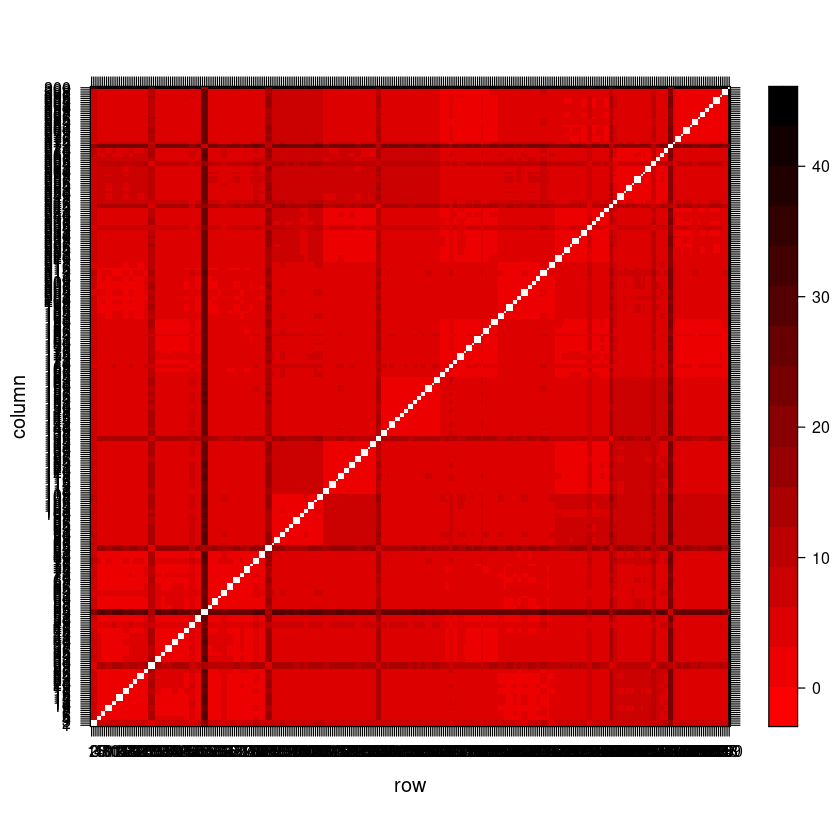

In [24]:
redblack = colorRampPalette(c("red", "black"))(100)
levelplot(low[[200]], col.regions = redblack)